In [196]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
from tqdm import tqdm
from skimage.filters import rank, threshold_otsu
from scipy import ndimage as ndi
from skimage.morphology import disk, ball, remove_small_objects, dilation, erosion
from skimage.segmentation import watershed, find_boundaries, relabel_sequential

def watershed_refinement(image, mask, save_dir=None):
    """Apply watershed to the given predictions with the goal of refine the boundaries of the artifacts. This function
       was implemented using scikit instead of opencv as :meth:`post_processing.boundary_refinement_watershed`.

       Based on https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_watershed.html.

       Parameters
       ----------
       X : 4D Numpy array
           Original data to guide the watershed. E.g. ``(img_number, y, x, channels)``.

       Y_pred : 4D Numpy array
           Predicted data to refine the boundaries. E.g. ``(img_number, y, x, channels)``.

       save_marks_dir : str, optional
           Directory to save the markers used to make the watershed. Useful for debugging.

       Returns
       -------
       Array : 4D Numpy array
           Refined boundaries of the predictions. E.g. ``(img_number, y, x, channels)``.
    """

    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)

    watershed_predictions = np.zeros(mask.shape, dtype=np.uint8)
    for ch in range(image.shape[-1]):
        markers = rank.gradient(mask[:,:,ch], disk(12)) < 10
        markers = ndi.label(markers)[0]
        # plt.figure()
        # plt.imshow(markers)
        # plt.title(f"Channel {ch} - Markers after mask gradient filter and ndi.label")
        gradient = rank.gradient(image[:,:,ch], disk(2))
        # plt.figure()
        # plt.imshow(gradient)
        # plt.title(f"Channel {ch} - Gradient after image gradient filter")
        labels = watershed(gradient, markers)
        watershed_predictions[:,:,ch] = labels
        
        if save_dir is not None:
            f = os.path.join(save_dir, "mark_" + str(ch) + ".png")
            cv2.imwrite(f, markers)

        # plt.figure()
        # plt.imshow(labels)
        # plt.title(f"Channel {ch} - Watershed labels")
        
    # for i in range(watershed_predictions.shape[-1]):
    #     plt.figure()
    #     plt.imshow(watershed_predictions[:,:,i], cmap='gray')
    #     plt.title(f"Channel {i} - Watershed predictions - unique values {np.unique(watershed_predictions[:,:,i])}")

    #mean of the 3 channels
    # print(f"Unique values before mean: {np.unique(watershed_predictions)}")
    watershed_predictions = np.mean(watershed_predictions, axis=-1)
    # print(f"Unique values after mean: {np.unique(watershed_predictions)}")
    # Label all artifacts into 1 and the background with 0
    watershed_predictions[watershed_predictions==1] = 0
    watershed_predictions[watershed_predictions>1] = 1

    return np.expand_dims(watershed_predictions, -1)

In [197]:
# Example usage
image = cv2.imread('/mnt/atlas/data_KPIs/data/KPIs24_Training_Data/Task1_patch_level/split/fold_0/56Nx/12_169/img/56Nx_12_169_89_19456_2048_img.jpg')
mask = cv2.imread('/mnt/atlas/data_KPIs/data/KPIs24_Training_Data/Task1_patch_level/split/fold_0/56Nx/12_169/mask/56Nx_12_169_89_19456_2048_mask.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [198]:
mask_refined = watershed_refinement(image, mask)

Unique values before mean: [1 2 3]
Unique values after mean: [1.         1.33333333 1.66666667 2.         2.33333333 3.        ]


In [200]:
np.unique(mask_refined)

array([0., 1.])

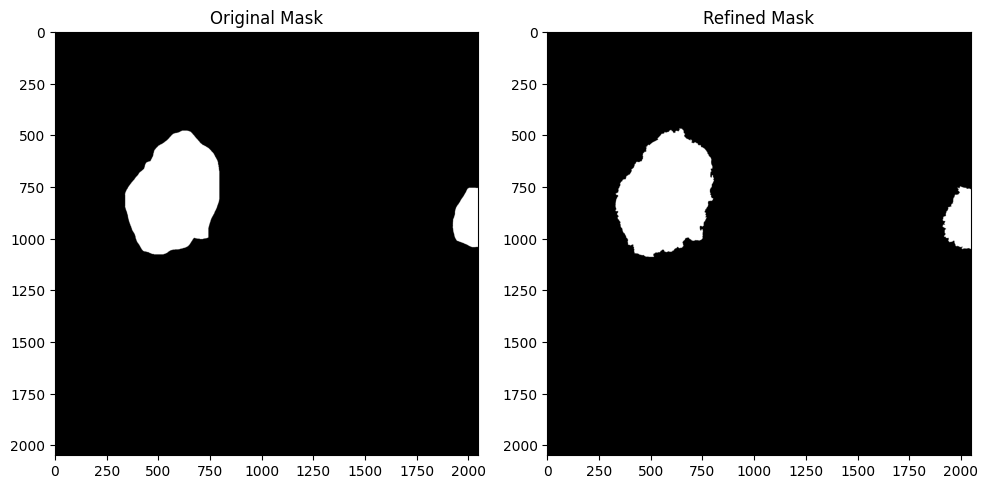

In [199]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(mask[:, :, 0], cmap='gray')
plt.title('Original Mask')

plt.subplot(1, 2, 2)
plt.imshow(mask_refined[:, :, 0], cmap='gray')
plt.title('Refined Mask')

plt.tight_layout()
plt.show()
